In [1]:
import pickle
import numpy as np
import random
import copy
import sys

## Mitigation via contact tracing

This requires the following repos:

* https://github.com/sibyl-team/sib
* https://github.com/sibyl-team/epidemic_mitigation

to be checked out in the same level as the repo containing this notebook so they can be accessed from notebook's code

Follow any additional installation instructions from these repos, sib in particular requires to install libomp via brew (on mac).

In [2]:
sib_folder = "../sib/" # sib path
ranker_folder = "../epidemic_mitigation/src/"
sys.path.insert(0, sib_folder)
sys.path.insert(0, ranker_folder)

In [3]:
# Input data to use
foldername = './data/195/'

# For reproducibility
seed = 247293

In [4]:
# reading node states

with open(foldername + 'daily-node-states-idx0.pickle', 'rb') as f:
    free_states = pickle.load(f)
T = len(free_states) # number of time-steps
N = len(free_states[0]) # number of individuals
T, N

(109, 128)

In [5]:
# reading states (ASK)
# 0 -> Susceptible
# 1 -> Case "0" (Self-infections)
# 2 -> Infected
# 3 -> Dead
# 4 -> Recovered
# 5 -> Vaccinated

map_to_sir = {}
map_to_sir[0] = 0
map_to_sir[1] = 1
map_to_sir[2] = 1
map_to_sir[3] = 2
map_to_sir[4] = 2
map_to_sir[5] = 2

In [6]:
#reading contacts
contacts = np.load(foldername + 'daily-contact-matrices.npy')
contacts.shape
# here, you have T x N x N. Entries contain the contact time (MINUTES?)

(110, 128, 128)

In [7]:
# shift time index (first contact matrices are zeros)
t = 0
while sum(sum(contacts[t])) == 0:
    t = t+1
tstart = t
print(tstart)

4


In [8]:
# get transmissions
transmissions = np.load(foldername + 'daily-transmissions-idx0.npy', allow_pickle=True)

In [9]:
# check transmissions 
for t in range(0, T):
    for i,j in transmissions[t]:
        if free_states[t][j] == 2:
            print(j, "infected today and already infective:", free_states[t][j])
            # set to 0 at the infection day 
            free_states[t][j] = 0
        if(free_states[t][i] == 0 or free_states[t][i] > 2): # only 191 data
            print(i, "is in state", free_states[t][i], "and infective") 
            print("yesterday was", free_states[t-1][i])
            free_states[t][i] = free_states[t-1][i]

# NOTE THAT
# ### infections occur synchronously 
# ### transition "I" -> "R" occurs before infections, so "R" are infective that day (in data 191)

84 infected today and already infective: 2
48 infected today and already infective: 2
25 infected today and already infective: 2
0 infected today and already infective: 2
30 infected today and already infective: 2
72 infected today and already infective: 2
3 infected today and already infective: 2
83 infected today and already infective: 2
44 infected today and already infective: 2
22 infected today and already infective: 2
104 infected today and already infective: 2
81 infected today and already infective: 2
85 infected today and already infective: 2
20 infected today and already infective: 2
114 infected today and already infective: 2
8 infected today and already infective: 2
41 infected today and already infective: 2
43 infected today and already infective: 2
56 infected today and already infective: 2
99 infected today and already infective: 2
53 infected today and already infective: 2
58 infected today and already infective: 2
36 infected today and already infective: 2
15 infected 

In [10]:
# build inference strategy
from rankers import greedy_rank, mean_field_rank, sib_rank
import sib

prob_seed = 1/N
prob_sus = 0.55
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-15
fp_rate = 1e-15
fnr = 1e-15 # one can put a realistic number
fn_rate = max(fnr, 1e-15)
num_threads = 1

rankers = {}


rankers["MF"] = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = 1/T,
                lamb = 0.01,
                )

rankers["greedy"] = greedy_rank.GreedyRanker(
                include_S = True,
                tau = 7, 
                )

rankers["BP"] = sib_rank.SibRanker(
                 params = sib.Params(
                    prob_i = sib.Uniform(1.0),
                    prob_r = sib.Exponential(mu=1/T),
                    pseed = pseed,
                    psus = psus,
                    pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau = 7,
                 fnr=fn_rate,
                 fpr=fp_rate,
)

sib.set_num_threads(num_threads)

In [11]:
frac_inf = 0.01 # randomly observed infected
nrnd = int(frac_inf * N)
print("Daily random observation(s):", nrnd)
beta = 0.01 # infection rate
t_mitig = 40 - tstart
num_test_algo = 2

Daily random observation(s): 1


In [12]:
class dummy_logger():
    def __init__(self):
        self.description = "This shape has not been described yet"
    def info(self, s):
        return True

In [13]:
states = copy.deepcopy(free_states)
res = {}
data = {}

# free dynamics
data["logger"] = dummy_logger()
data["nS"] = [N]
data["nI"] = [0]
data["nR"] = [0]

for internal_t in range(tstart, T):
    nS, nI, nR = states[internal_t].count(0), states[internal_t].count(1) + states[internal_t].count(2), states[internal_t].count(3) + states[internal_t].count(4) + states[internal_t].count(5)
    data["nS"].append(nS)
    data["nI"].append(nI)
    data["nR"].append(nR)
res["free"] = data

# mitigated spreading
for s in rankers.keys():
    rankers[s].init(N, T - tstart)
    rng = np.random.RandomState(seed)
    random.seed(seed+1)
    quar = []
    obs_today = []
    obs_today_rank = []
    daily_obs = []
    data = {}
    data["logger"] = dummy_logger()
    data["nS"] = [N]
    data["nI"] = [0]
    data["nR"] = [0]
    data["nQ"] = [0]
    
    # reset states
    for internal_t in range(0, T):
        for i in range(0, N):
            states[internal_t][i] = free_states[internal_t][i]
            
    for internal_t in range(tstart, T):
        t = internal_t - tstart
        
        # check transmissions according to mitigation policy (erase transmission trees of individuals in isolation)
        transms_today = transmissions[internal_t]
        for infector, infected in transms_today:
            if states[internal_t][infector] == 0 or infector in quar:
                #print("infector", infector, "infected", infected, "internal_t", internal_t)
                for taux in range(internal_t, T):
                    states[taux][infected] = 0
                     
        # get states for plotting
        nS, nI, nR = states[internal_t].count(0), states[internal_t].count(1) + states[internal_t].count(2), states[internal_t].count(3) + states[internal_t].count(4) + states[internal_t].count(5)
        data["nS"].append(nS)
        data["nI"].append(nI)
        data["nR"].append(nR)
        
        # get contacts
        idx_x, idx_y = np.nonzero(contacts[internal_t])
        len_c = len(idx_x)
        daily_contacts = [(int(idx_x[c]), int(idx_y[c]), t, float(1 - np.exp(-beta * contacts[internal_t][idx_x[c], idx_y[c]]))) for c in range(0, len_c) if idx_x[c] < idx_y[c]]
        
        # call inference methods 
        rank_algo = rankers[s].rank(t, daily_contacts, daily_obs, data)
        rank = np.array(sorted(rank_algo, key= lambda tup: tup[1], reverse=True))
    
        # get random observations
        if t >= t_mitig:
            indices = [i for i in range(0,N) if (states[internal_t][i] == 2 and i not in quar)]
            obs_today = rng.permutation(indices)[0:nrnd].tolist()
            quar = quar + obs_today
    
        # get inference-based observations
        infected_today_rank = []
        if t > t_mitig:
            obs_today_rank = [int(tup[0]) for tup in rank if (int(tup[0]) not in quar)][0:num_test_algo]
            infected_today_rank = [i for i in obs_today_rank if map_to_sir[states[internal_t][i]] == 1]
            quar = quar  + infected_today_rank
        data["nQ"].append(len(infected_today_rank))
        daily_obs = [(int(i), map_to_sir[states[internal_t][i]], t) for i in obs_today + obs_today_rank]
    data["quar"] = quar
    res[s] = data

all contacts: 1
all contacts cut: 0
all contacts: 5
all contacts cut: 0
all contacts: 6
all contacts cut: 0
all contacts: 14
all contacts cut: 0
all contacts: 46
all contacts cut: 0
all contacts: 148
all contacts cut: 0
all contacts: 187
all contacts cut: 0
all contacts: 250
all contacts cut: 0
all contacts: 267
all contacts cut: 0
all contacts: 284
all contacts cut: 0
all contacts: 300
all contacts cut: 0
all contacts: 367
all contacts cut: 0
all contacts: 443
all contacts cut: 0
all contacts: 476
all contacts cut: 0
all contacts: 549
all contacts cut: 0
all contacts: 574
all contacts cut: 0
all contacts: 664
all contacts cut: 0
all contacts: 720
all contacts cut: 0
all contacts: 776
all contacts cut: 0
all contacts: 783
all contacts cut: 0
all contacts: 745
all contacts cut: 0
all contacts: 679
all contacts cut: 0
all contacts: 637
all contacts cut: 0
all contacts: 616
all contacts cut: 0
all contacts: 582
all contacts cut: 0
all contacts: 568
all contacts cut: 0
all contacts: 569
al

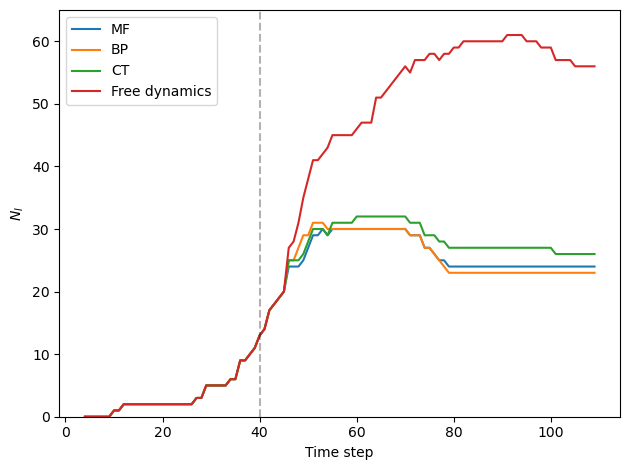

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(tstart, T+1), res["MF"]["nI"], label = "MF")
plt.plot(range(tstart, T+1), res["BP"]["nI"], label = "BP")
plt.plot(range(tstart, T+1), res["greedy"]["nI"], label = "CT")
plt.plot(range(tstart, T+1), res["free"]["nI"], label = "Free dynamics")
plt.vlines(t_mitig + tstart, ymin = 0,ymax = 70,linestyle = "--", alpha = 0.3, color = "black")
plt.ylim([0, 65])
plt.xlabel("Time step")
plt.ylabel("$N_{I}$")

plt.plot()
plt.tight_layout()
plt.legend()

In [15]:
# Q cumulative
for s in rankers.keys():
    res[s]["nQ_cum"] = [0]
    for t in range(1, len(res[s]["nQ"])):
        res[s]["nQ_cum"].append(res[s]["nQ_cum"][t-1] + res[s]["nQ"][t])

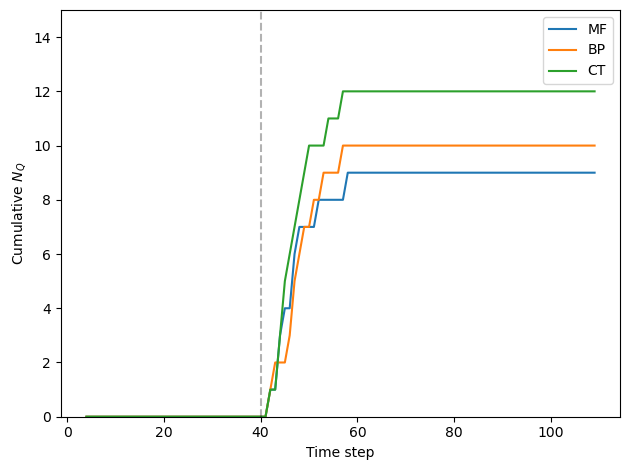

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(tstart, T+1), res["MF"]["nQ_cum"], label = "MF")
plt.plot(range(tstart, T+1), res["BP"]["nQ_cum"], label = "BP")
plt.plot(range(tstart, T+1), res["greedy"]["nQ_cum"], label = "CT")
#plt.plot(range(tstart, T+1), res["free"]["nQ"], label = "Free dynamics")
plt.vlines(t_mitig + tstart, ymin = 0,ymax = 70,linestyle = "--", alpha = 0.3, color = "black")
plt.ylim([0, 15])
plt.xlabel("Time step")
plt.ylabel("Cumulative $N_{Q}$")

plt.plot()
plt.tight_layout()
plt.legend()